In [1]:
import torch
from torch.utils.data import SubsetRandomSampler

from src.dataset import ImageDataset
from src.utils import get_indices, FFTloss, plot_result
from src.mwcnn import MWCNN
from src.training import Trainer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset part used for testing
TEST_SPLIT = 0.2
# Batch size for training. Limited by GPU memory
BATCH_SIZE = 6
# Dataset folder used
DATASETS = ['e9_5_GLM87a_cycle1_8_8', 'e12_5_slide7_round1_section1']
ROOTDIR = 'data\mip2edof_2samples'
# Training Epochs
EPOCHS = 100

c:\Users\jurri\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\jurri\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

## 1 Initiate train and test loader

In [2]:
image_dataset = ImageDataset(ROOTDIR, DATASETS)

train_indices, test_indices = get_indices(len(image_dataset), image_dataset.root_dir, TEST_SPLIT)
train_sampler, test_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(test_indices)

trainloader = torch.utils.data.DataLoader(image_dataset, BATCH_SIZE, sampler=train_sampler)
testloader = torch.utils.data.DataLoader(image_dataset, 1, sampler=test_sampler)

c:\Users\jurri\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


## 1.1 Show example of images

In [3]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60))
# for data in trainloader:
#     input_image = data['input_image'].squeeze().permute(1, 2, 0)
#     output_image = data['output_image'].squeeze().permute(1, 2, 0)
#     for i in range(input_image.shape[2]):
#         ax[i,0].imshow(input_image[:,:,i], cmap='gray', vmin=0, vmax=16383, aspect='equal')
#         ax[i,1].imshow(output_image[:,:,i], cmap='gray', vmin=0, vmax=16383, aspect='equal')
#     break

# plt.tight_layout()

## 2 Initiate model

In [4]:
MWCNN_model = MWCNN(n_feats=16, n_colors=1).to(device)

## 3. Model Training and Testing

In [6]:
# Training
criterion = FFTloss()
MWCNN_trainer = Trainer(MWCNN_model, criterion, device)

In [5]:
loss_record = MWCNN_trainer.train(EPOCHS,trainloader,mini_batch=5)

print(f'Training finished!')

Starting Training Process
Batch: 05,	Batch Loss: 11216947.8666667
Batch: 10,	Batch Loss: 5139392.5333333
Batch: 15,	Batch Loss: 4659051.9000000
Epoch: 001,  Loss:7005130.7666667,  
Batch: 05,	Batch Loss: 5897758.9333333
Batch: 10,	Batch Loss: 5393483.4666667
Batch: 15,	Batch Loss: 4480940.0000000
Epoch: 002,  Loss:5257394.1333333,  
Batch: 05,	Batch Loss: 4831366.3666667
Batch: 10,	Batch Loss: 5348653.7000000
Batch: 15,	Batch Loss: 5892595.0666667
Epoch: 003,  Loss:5357538.3777778,  
Batch: 05,	Batch Loss: 5364634.9000000
Batch: 10,	Batch Loss: 5881545.8000000
Batch: 15,	Batch Loss: 4533817.6000000
Epoch 00004: reducing learning rate of group 0 to 8.5000e-04.
Epoch: 004,  Loss:5259999.4333333,  
Batch: 05,	Batch Loss: 5706371.1333333
Batch: 10,	Batch Loss: 3918449.8000000
Batch: 15,	Batch Loss: 4716124.0333333
Epoch: 005,  Loss:4780314.9888889,  
Batch: 05,	Batch Loss: 6354203.0666667
Batch: 10,	Batch Loss: 4788160.9333333
Batch: 15,	Batch Loss: 3916349.8333333
Epoch: 006,  Loss:501957

KeyboardInterrupt: 

## Test model

In [ ]:
# Testing process on test data.
mwcnn_psnr, mwcnn_mse = MWCNN_trainer.test(testloader)
print(f'PSNR: {mwcnn_psnr}, MSE: {mwcnn_mse}')

## Save model

In [6]:
# save the model
torch.save(MWCNN_model, 'MWCNN_model_fft_16.pth')

## Show predictions from trained models

In [3]:
# load model
MWCNN_model = torch.load('MWCNN_model_L1loss_16.pth')
# make trainer for testing, predicting and possibly more training
criterion = FFTloss()
MWCNN_trainer = Trainer(MWCNN_model, criterion, device)

Do x predictions

In [4]:
num_pred = 3
results = []
for i in range(num_pred):
    image_index = test_indices[i]
    sample = image_dataset[image_index]
    mip, pred, edof, original_score, improved_score = MWCNN_trainer.predict(sample)
    results.append({
        "MIP": mip,
        "pred": pred,
        "EDOF": edof,
        "original_score": original_score,
        "improved_score": improved_score
    })

c:\Users\jurri\Documents\University\Life sciences and engineering\Deep learning in biomedicine\project\deep-biomedicine-project\src\utils.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


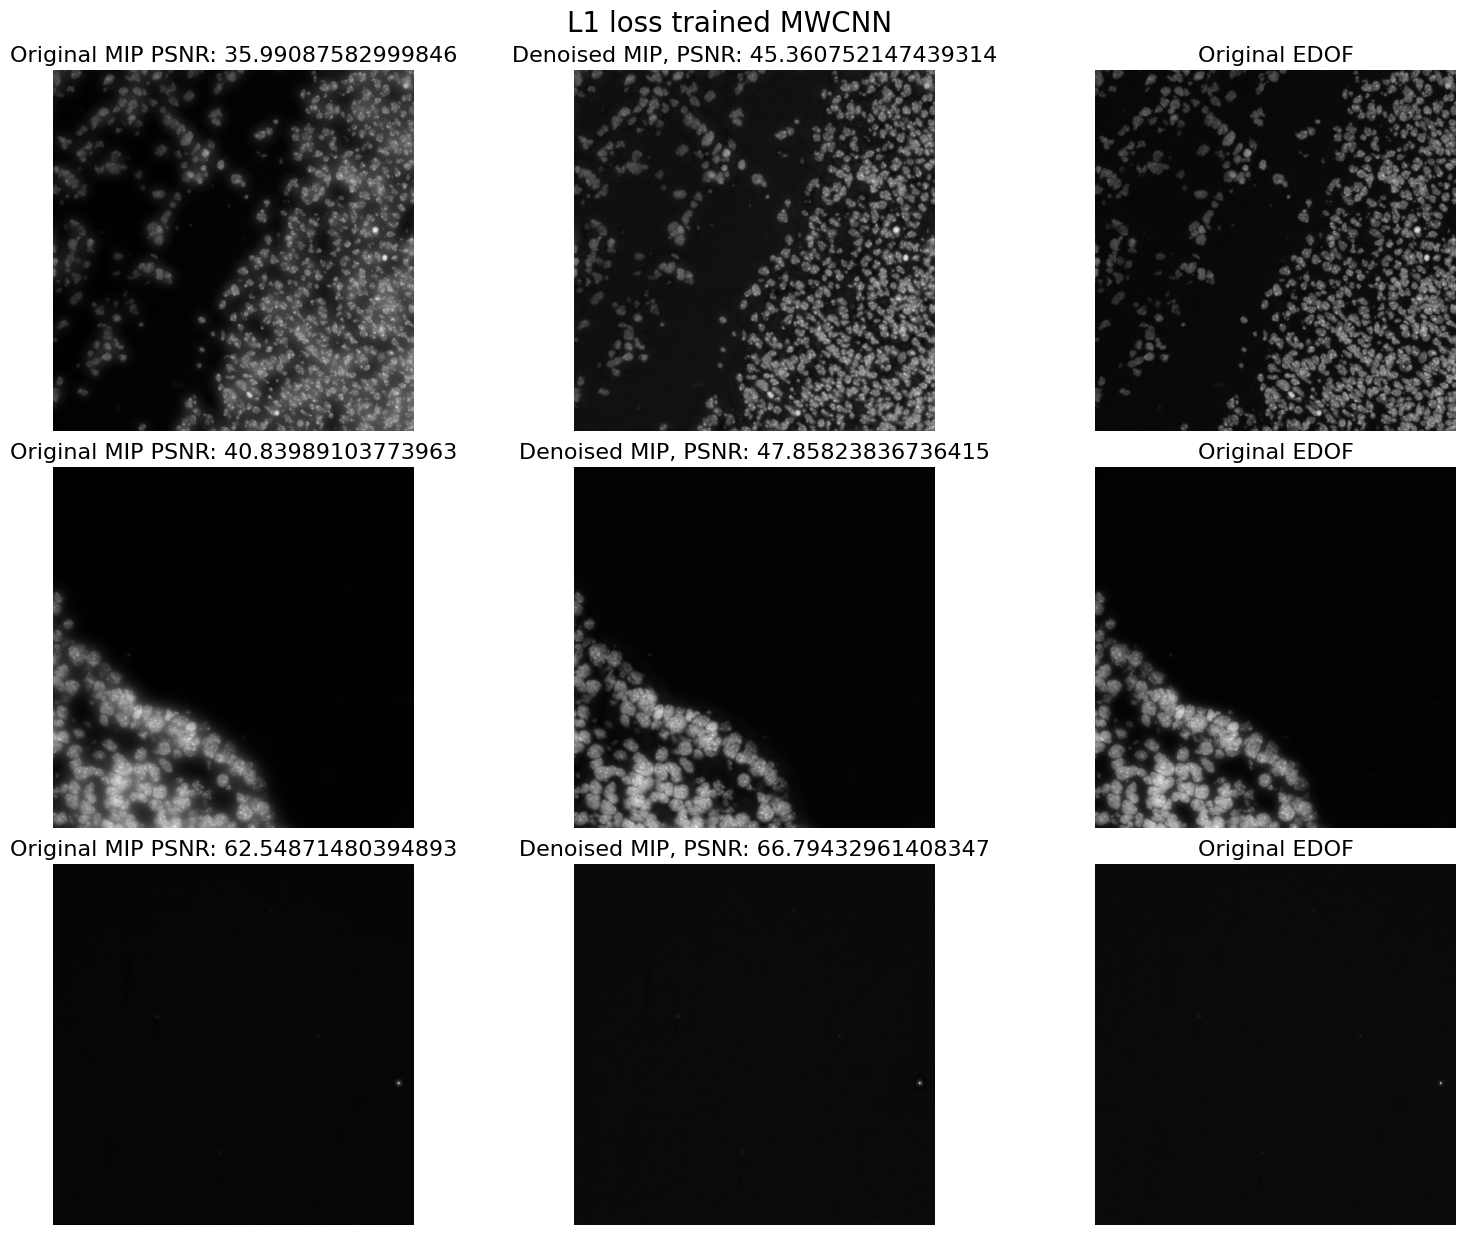

In [5]:
# plot results
plot_result(results, "L1 loss trained MWCNN")

In [6]:
# load model
MWCNN_model = torch.load('MWCNN_model_fft_16.pth')
# make trainer for testing, predicting and possibly more training
criterion = FFTloss()
MWCNN_trainer = Trainer(MWCNN_model, criterion, device)

In [7]:
results = []
for i in range(num_pred):
    image_index = test_indices[i]
    sample = image_dataset[image_index]
    mip, pred, edof, original_score, improved_score = MWCNN_trainer.predict(sample)
    results.append({
        "MIP": mip,
        "pred": pred,
        "EDOF": edof,
        "original_score": original_score,
        "improved_score": improved_score
    })

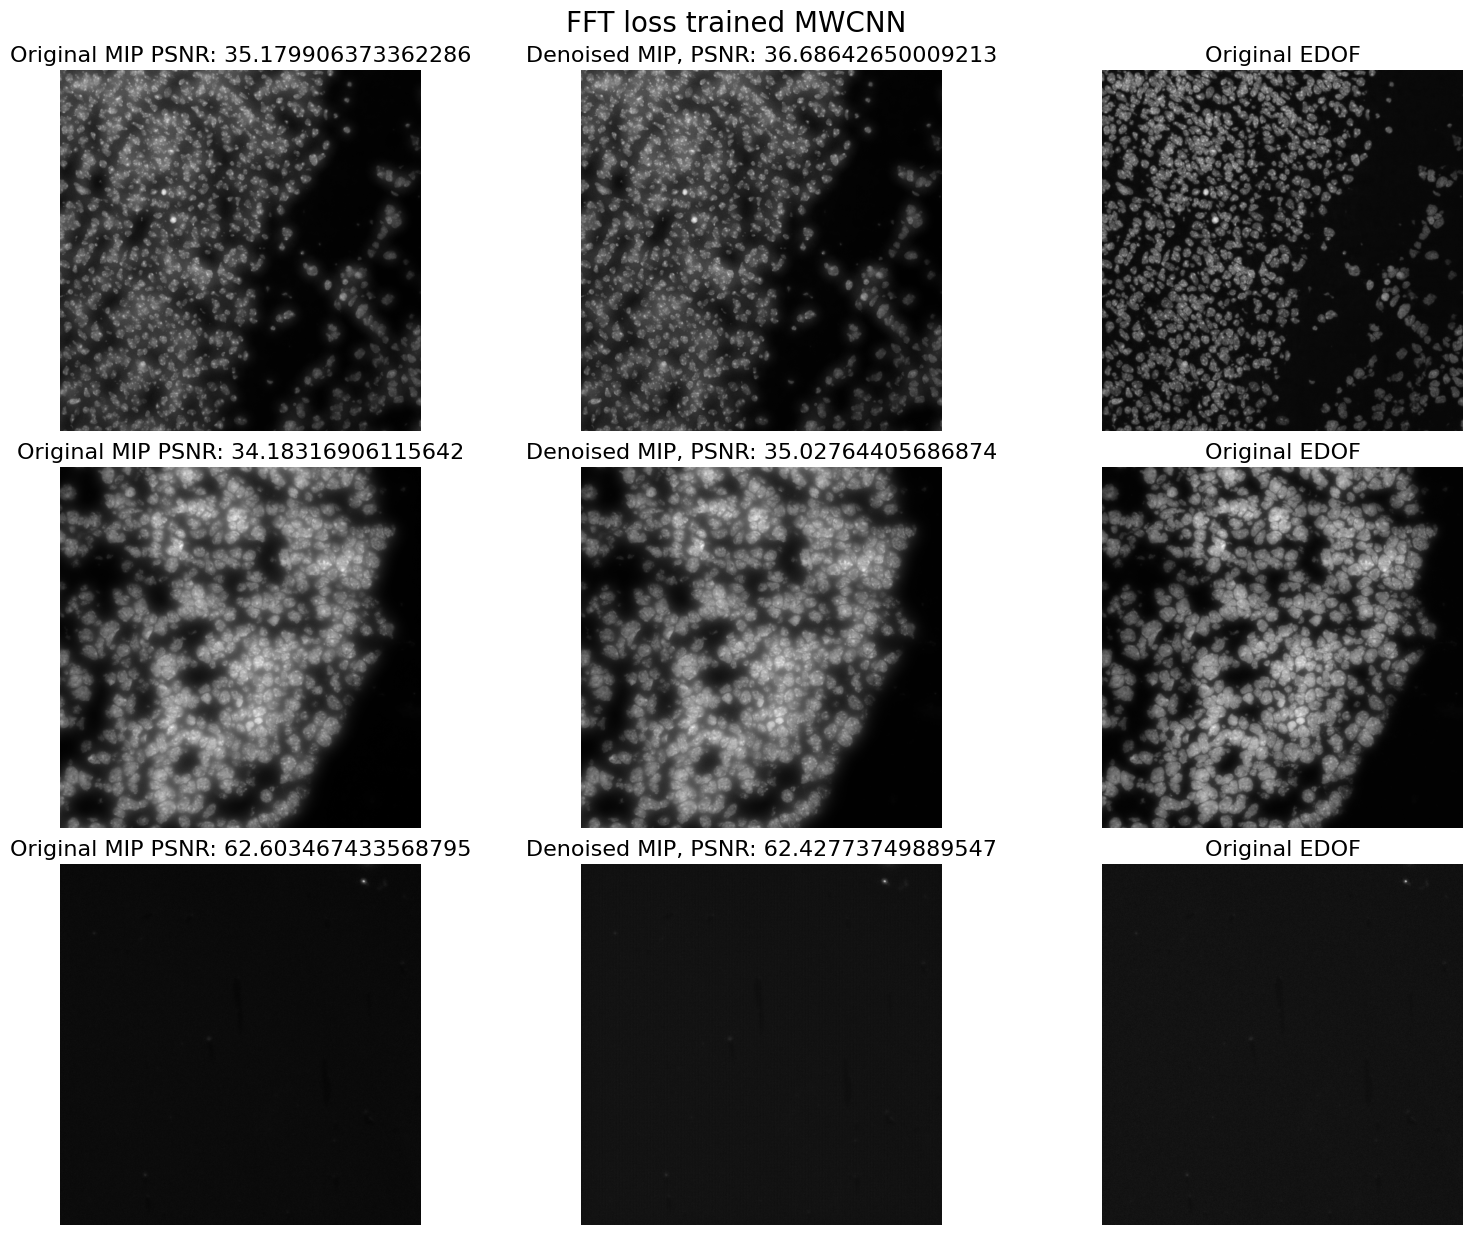

In [8]:
# plot results
plot_result(results, "FFT loss trained MWCNN")